In [1]:
#config
from sklearn import set_config
set_config(display = "diagram")

#built in
import os 

#HTML
from IPython.core.display import HTML

#data
import pandas as pd
import numpy as np

#preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, RobustScaler
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, KBinsDiscretizer

#pipeline
from sklearn.pipeline import Pipeline, make_pipeline

#compose
from sklearn.compose import ColumnTransformer, make_column_transformer

#Estimator
from sklearn.linear_model import ElasticNet, LinearRegression, Ridge, Lasso
from sklearn.svm import SVR, LinearSVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import AdaBoostRegressor

#feature selection
from sklearn.feature_selection import VarianceThreshold

#model selection
from sklearn.model_selection import train_test_split, GridSearchCV

#metrics
from sklearn.metrics import r2_score,mean_squared_error, SCORERS

#clone
from sklearn.base import clone

#yellowbrick
from yellowbrick.datasets import load_concrete
from yellowbrick.regressor import cooks_distance

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)

sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')

plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

# 1 -Preparation des données

## 1.1 - Chargement

In [3]:
source = 'data/cleaned/'
filename = 'df_clean2.csv'
df = pd.read_csv(source + filename, index_col = 0)

In [4]:
df.shape

(2384, 43)

In [5]:
cond = df['ENERGYSTARScore'].isna()
rqdIndex = df[cond].index
df.drop(rqdIndex, axis = 0, inplace = True)

In [6]:
df.shape

(1646, 43)

In [7]:
df.columns

Index(['BuildingType', 'PrimaryPropertyType', 'CouncilDistrictCode',
       'Neighborhood', 'Latitude', 'Longitude', 'YearBuilt',
       'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'PropertyGFABuilding(s)',
       'LargestPropertyUseType', 'LargestPropertyUseTypeGFA',
       'SecondLargestPropertyUseType', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseType', 'ThirdLargestPropertyUseTypeGFA',
       'ENERGYSTARScore', 'SiteEUI(kBtu/sf)', 'SiteEUIWN(kBtu/sf)',
       'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)',
       'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)', 'Electricity(kWh)',
       'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)',
       'DefaultData', 'ComplianceStatus', 'Outlier', 'TotalGHGEmissions',
       'GHGEmissionsIntensity', 'NonResidentialGFA', 'delta_Site_WM',
       'delta_Source_WM', 'Delta_Site_Source', 'Delta_Site_Source_WN',
       'ratio_Site_Source_WN', 'NaturalGaz

### Fonction pour afficher les resultats dans une DF

In [8]:
#fonction qui renvoie la R2 et Rmse
def score_p(modele, X, y):
    y_pred = modele.predict(X)
    rmse = mean_squared_error(y, y_pred, squared = False).round(2)
    r2 = r2_score(y, y_pred).round(2)
    
    return rmse, r2

In [9]:
def add_result(df, data):
    df = df.copy()
    df = df.append(data,  ignore_index= True)
    return df

In [10]:
#fonction pour calculer le R2 et rmse
def summary( modele, df, X_train, X_test, y_train , y_test, 
            ensembliste = 'non',target ='TotalGHGEmissions',commentaires = ""):

    #recupération nom du modele
    nom_modele = modele[-1].__class__.__name__
    
    #Calcul du rmse et r2
    #train set
    train_rmse = score_p(modele, X_train, y_train)[0]
    train_r2 = score_p(modele, X_train, y_train)[1]
    
    #test set
    test_rmse = score_p(modele, X_test, y_test)[0]
    test_r2 = score_p(modele, X_test, y_test)[1]
    
    #On ajoute les données dans la DataFrame
    
    data = {'Modele' : nom_modele,'Ensembliste':ensembliste,'Target' : target,
               'Train_RMSE': train_rmse,'Test_RMSE' : test_rmse,'Train_R2' : train_r2,
               'Test_R2' : test_r2, 'Commentaires' : commentaires}
    df = add_result(df, data)
    return df

In [11]:
#Creation de la dataframe Summary
df_summary = pd.DataFrame(columns = ['Modele','Ensembliste','Target','Train_RMSE','Test_RMSE','Train_R2',
            'Test_R2', 'Commentaires'])
df_summary

,Modele,Ensembliste,Target,Train_RMSE,Test_RMSE,Train_R2,Test_R2,Commentaires


### 1.2 Train test split

In [12]:
target = 'TotalGHGEmissions'

In [13]:
cond = df['TotalGHGEmissions']<0
df[cond]['TotalGHGEmissions']
df.drop(df[cond].index, axis = 0, inplace= True)

In [14]:
X = df.copy().drop([target], axis =1)
y = df.copy()[target]
y_trans = np.log1p(y)

In [15]:
#nous n'avonbs pas utiliséla transformation logarithmique sur la variable cible

In [16]:
#stratification des données
df['TotalGHGEmissions_q'] = pd.qcut(df['TotalGHGEmissions'],10)
df['TotalGHGEmissions_q'].value_counts()

(0.809, 6.054]        165
(11.012, 20.104]      165
(30.832, 46.46]       165
(94.638, 148.694]     165
(269.72, 16870.98]    165
(6.054, 11.012]       164
(20.104, 30.832]      164
(46.46, 65.258]       164
(65.258, 94.638]      164
(148.694, 269.72]     164
Name: TotalGHGEmissions_q, dtype: int64

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size =0.3,
                                                    random_state = 18,
                                                    shuffle = True,
                                                    stratify = df['TotalGHGEmissions_q'])

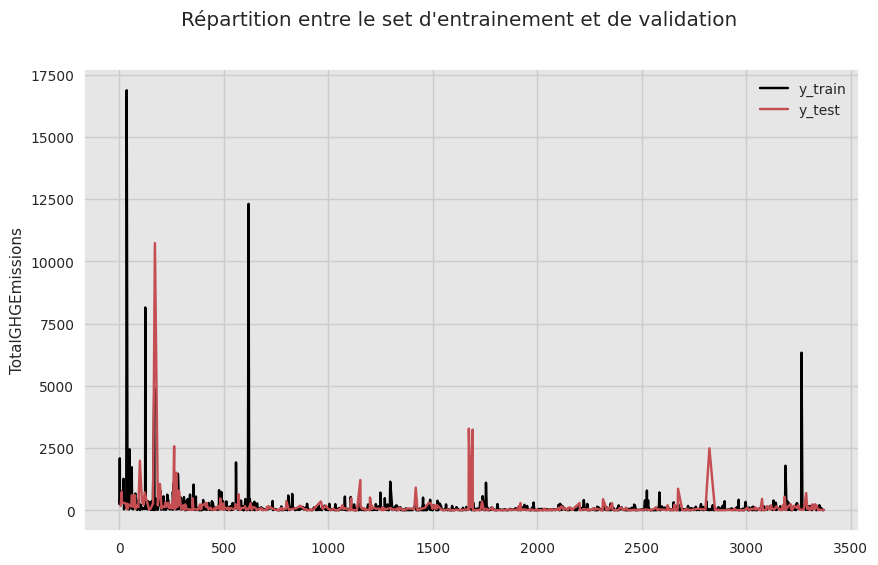

In [18]:
fig, ax = plt.subplots()
sns.lineplot(x=y_train.index, y= y_train, color ='black', label ='y_train', ax =ax)
sns.lineplot(x=y_test.index, y = y_test, color = sns_c[3], label ='y_test', ax=ax)
plt.suptitle("Répartition entre le set d'entrainement et de validation")
plt.show()

### 1.3 - Model Developpement

In [19]:
#features:
numeric_features = [
    'LargestPropertyUseTypeGFA',
    'SecondLargestPropertyUseTypeGFA',
    'ThirdLargestPropertyUseTypeGFA',
    'Electricity_p',
    'NaturalGaz_p',
    'Latitude',
    'Longitude',
    'NonResidentialGFA',
    'PropertyGFAParking',
    'PropertyGFABuilding(s)',
    'ENERGYSTARScore']


categorical_features = [
    'PrimaryPropertyType',
    'BuildingType',
    'LargestPropertyUseType']

features = numeric_features + categorical_features

In [20]:
X_train = X_train[features]
X_test = X_test[features]

In [147]:
X_train.loc[[55]]

,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,Electricity_p,NaturalGaz_p,Latitude,Longitude,NonResidentialGFA,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,PrimaryPropertyType,BuildingType,LargestPropertyUseType
55,155602.0,0.0,0.0,0.666814,0.333186,47.62023,-122.35951,155602,36744,118858,81.0,Hotel,NonResidential,Hotel


### 1.4 - Preprocessor

In [21]:
#centrage et réduction des données
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler())
])

In [22]:
#transformation des variables categorielles
categorical_transformer = Pipeline(steps = [
    ('one_hot', OneHotEncoder(handle_unknown = 'ignore'))
])

In [23]:
#Recuperation des noms de colonnes apres les transformations
categorical_features_ext = list(categorical_transformer['one_hot']\
                                .fit(X_train[categorical_features])\
                                .get_feature_names_out()
                               )
features_ext = categorical_features_ext + numeric_features
print(f'Number of features after preprocessing: {len(features_ext)}')

Number of features after preprocessing: 59


## 2 - Model Selection

### 2.1 - Linear Model

### preprocessor

In [24]:
linear_preprocessor = ColumnTransformer(transformers = [
    ('cat', categorical_transformer, categorical_features),
    ('num', numeric_transformer, numeric_features),
], remainder = 'passthrough')

In [25]:
linear_preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('cat',
                                 Pipeline(steps=[('one_hot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['PrimaryPropertyType', 'BuildingType',
                                  'LargestPropertyUseType']),
                                ('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['LargestPropertyUseTypeGFA',
                                  'SecondLargestPropertyUseTypeGFA',
                                  'ThirdLargestPropertyUseTypeGFA',
                                  'Electricity_p', 'NaturalGaz_p', 'Latitude',
                                  'Longitude', 'NonResidentialGFA',
                                  'PropertyGFAParking',
                                  'PropertyGFABuilding(s)',
                                  'ENERGYSTARScore'])])

### engineering

In [26]:
#For linear regressor
linear_feature_engineering = Pipeline(steps = [
    ('linear_preprocessor', linear_preprocessor),
    ('polynomial', PolynomialFeatures(degree = 2, include_bias = False)),
    ('variance_threshold', VarianceThreshold())
])


In [27]:
linear_feature_engineering

Pipeline(steps=[('linear_preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['PrimaryPropertyType',
                                                   'BuildingType',
                                                   'LargestPropertyUseType']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['LargestPropertyUseTypeGFA',
                                                   'SecondLargestPropertyUseTypeGFA',
                                                   'ThirdLargestPropertyUseTypeGFA',
                                                   'Electricity_p',
                                                   'NaturalGaz_p', 'Latitude',
                                                   'Longitude',
                                                   'NonResidentialGFA',
                                                   'PropertyGFAParking',
                                                   'PropertyGFABuilding(s)',
                                                   'ENERGYSTARScore'])])),
                ('polynomial', PolynomialFeatures(include_bias=False)),
                ('variance_threshold', VarianceThreshold())])

### 2.1.1 - Dummy Regressor

In [28]:
dummy = Pipeline(steps = [
    ('linear_feature_engineering', linear_feature_engineering),
    ('regressor', DummyRegressor(strategy="mean"))
])

In [29]:
dummy.fit(X_train, y_train)
df_summary = summary(dummy, df_summary,X_train, X_test, y_train, y_test)
df_summary

,Modele,Ensembliste,Target,Train_RMSE,Test_RMSE,Train_R2,Test_R2,Commentaires
0,DummyRegressor,non,TotalGHGEmissions,721.77,568.83,0.0,-0.0,


### 2.1.2 - Lasso

In [30]:
lasso = Pipeline(steps = [
    ('linear_feature_engineering', linear_feature_engineering),
    ('regressor', Lasso(max_iter = 8000))
])

In [31]:
#Recherche des meilleurs hyperparametres
lasso_param_grid = {
    'linear_feature_engineering__polynomial__degree' : [1,2],
    'regressor__alpha' : np.logspace(-3,3,20),
    'linear_feature_engineering__polynomial__interaction_only' : [True]
}

lasso_grid_search = GridSearchCV(
    estimator = lasso,
    param_grid = lasso_param_grid,
    scoring = 'neg_root_mean_squared_error',
    cv = 3,
    verbose = 2,
    n_jobs = -1
)

In [32]:
lasso_grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('linear_feature_engineering',
                                        Pipeline(steps=[('linear_preprocessor',
                                                         ColumnTransformer(remainder='passthrough',
                                                                           transformers=[('cat',
                                                                                          Pipeline(steps=[('one_hot',
                                                                                                           OneHotEncoder(handle_unknown='ignore'))]),
                                                                                          ['PrimaryPropertyType',
                                                                                           'BuildingType',
                                                                                           'LargestPropertyUseType']),
                                                                                         ('num',
                                                                                          Pipeline(steps=[('scaler',
                                                                                                           Standar...
                         'regressor__alpha': array([1.00000000e-03, 2.06913808e-03, 4.28133240e-03, 8.85866790e-03,
       1.83298071e-02, 3.79269019e-02, 7.84759970e-02, 1.62377674e-01,
       3.35981829e-01, 6.95192796e-01, 1.43844989e+00, 2.97635144e+00,
       6.15848211e+00, 1.27427499e+01, 2.63665090e+01, 5.45559478e+01,
       1.12883789e+02, 2.33572147e+02, 4.83293024e+02, 1.00000000e+03])},
             scoring='neg_root_mean_squared_error', verbose=2)

In [33]:
lasso_grid_search.best_params_

{'linear_feature_engineering__polynomial__degree': 2,
 'linear_feature_engineering__polynomial__interaction_only': True,
 'regressor__alpha': 2.976351441631316}

In [34]:
lasso.set_params(**lasso_grid_search.best_params_).fit(X_train, y_train)
df_summary = summary(lasso, df_summary,X_train, X_test, y_train, y_test)
df_summary

,Modele,Ensembliste,Target,Train_RMSE,Test_RMSE,Train_R2,Test_R2,Commentaires
0,DummyRegressor,non,TotalGHGEmissions,721.77,568.83,0.00,-0.00,
1,Lasso,non,TotalGHGEmissions,78.16,166.90,0.99,0.91,


### 2.1.3 - Linear

In [35]:
linear = Pipeline(steps = [
    ('linear_feature_engineering', linear_feature_engineering),
    ('regressor', LinearRegression())
])

In [36]:
#Recherche des meilleurs hyperparametres
linear_param_grid = {
    'linear_feature_engineering__polynomial__degree' : [1,2,3],
    'regressor__fit_intercept': [True, False]
}

linear_grid_search = GridSearchCV(
    estimator = linear,
    param_grid = linear_param_grid,
    scoring = 'neg_root_mean_squared_error',
    cv = 3,
    verbose = 2,
    n_jobs = -1
)

In [37]:
linear_grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('linear_feature_engineering',
                                        Pipeline(steps=[('linear_preprocessor',
                                                         ColumnTransformer(remainder='passthrough',
                                                                           transformers=[('cat',
                                                                                          Pipeline(steps=[('one_hot',
                                                                                                           OneHotEncoder(handle_unknown='ignore'))]),
                                                                                          ['PrimaryPropertyType',
                                                                                           'BuildingType',
                                                                                           'LargestPropertyUseType']),
                                                                                         ('num',
                                                                                          Pipeline(steps=[('scaler',
                                                                                                           Standar...
                                                                                           'PropertyGFABuilding(s)',
                                                                                           'ENERGYSTARScore'])])),
                                                        ('polynomial',
                                                         PolynomialFeatures(include_bias=False,
                                                                            interaction_only=True)),
                                                        ('variance_threshold',
                                                         VarianceThreshold())])),
                                       ('regressor', LinearRegression())]),
             n_jobs=-1,
             param_grid={'linear_feature_engineering__polynomial__degree': [1,
                                                                            2,
                                                                            3],
                         'regressor__fit_intercept': [True, False]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [38]:
linear_grid_search.best_params_

{'linear_feature_engineering__polynomial__degree': 2,
 'regressor__fit_intercept': True}

In [39]:
linear.set_params(**linear_grid_search.best_params_).fit(X_train, y_train)
df_summary = summary(linear, df_summary,X_train, X_test, y_train, y_test)
df_summary

,Modele,Ensembliste,Target,Train_RMSE,Test_RMSE,Train_R2,Test_R2,Commentaires
0,DummyRegressor,non,TotalGHGEmissions,721.77,568.83,0.00,-0.00,
1,Lasso,non,TotalGHGEmissions,78.16,166.90,0.99,0.91,
2,LinearRegression,non,TotalGHGEmissions,26.98,251.78,1.00,0.80,


### 2.1.4 - Ridge

In [40]:
ridge = Pipeline(steps = [
    ('linear_feature_engineering', linear_feature_engineering),
    ('regressor', Ridge())
])

In [41]:
#Recherche des meilleurs hyperparametres
ridge_param_grid = {
    'linear_feature_engineering__polynomial__degree' : [1,2,3],
    'regressor__fit_intercept': [True, False]
}

ridge_grid_search = GridSearchCV(
    estimator = ridge,
    param_grid = ridge_param_grid,
    scoring = 'neg_root_mean_squared_error',
    cv = 3,
    verbose = 2,
    n_jobs = -1
)

In [42]:
ridge_grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('linear_feature_engineering',
                                        Pipeline(steps=[('linear_preprocessor',
                                                         ColumnTransformer(remainder='passthrough',
                                                                           transformers=[('cat',
                                                                                          Pipeline(steps=[('one_hot',
                                                                                                           OneHotEncoder(handle_unknown='ignore'))]),
                                                                                          ['PrimaryPropertyType',
                                                                                           'BuildingType',
                                                                                           'LargestPropertyUseType']),
                                                                                         ('num',
                                                                                          Pipeline(steps=[('scaler',
                                                                                                           Standar...
                                                                                           'PropertyGFABuilding(s)',
                                                                                           'ENERGYSTARScore'])])),
                                                        ('polynomial',
                                                         PolynomialFeatures(include_bias=False,
                                                                            interaction_only=True)),
                                                        ('variance_threshold',
                                                         VarianceThreshold())])),
                                       ('regressor', Ridge())]),
             n_jobs=-1,
             param_grid={'linear_feature_engineering__polynomial__degree': [1,
                                                                            2,
                                                                            3],
                         'regressor__fit_intercept': [True, False]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [43]:
ridge_grid_search.best_params_

{'linear_feature_engineering__polynomial__degree': 3,
 'regressor__fit_intercept': True}

In [44]:
ridge.set_params(**ridge_grid_search.best_params_).fit(X_train, y_train)
df_summary = summary(ridge, df_summary,X_train, X_test, y_train, y_test)
df_summary

,Modele,Ensembliste,Target,Train_RMSE,Test_RMSE,Train_R2,Test_R2,Commentaires
0,DummyRegressor,non,TotalGHGEmissions,721.77,568.83,0.00,-0.00,
1,Lasso,non,TotalGHGEmissions,78.16,166.90,0.99,0.91,
2,LinearRegression,non,TotalGHGEmissions,26.98,251.78,1.00,0.80,
3,Ridge,non,TotalGHGEmissions,12.13,256.68,1.00,0.80,


### 2.2 - Decision Tree regressor

### preprocessor

In [45]:
tree_preprocessor = ColumnTransformer(transformers = [
    ('cat', categorical_transformer, categorical_features),
], remainder = 'passthrough')

### engineering

In [46]:
tree_feature_engineering = Pipeline(steps = [
    ('tree_preprocessor', tree_preprocessor),
])

In [47]:
tree = Pipeline(steps = [
    ('tree_feature_engineering', tree_feature_engineering),
    ('regressor', DecisionTreeRegressor())
])

In [48]:
#Recherche des meilleurs hyperparamètres
tree_param_grid = {'regressor__max_depth' : [30,40,50],
              'regressor__min_samples_leaf' : [1,3,5,10],
             }

tree_grid_search = GridSearchCV(
    estimator=tree,
    param_grid=tree_param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs = -1,
    verbose = -1
)

In [49]:
tree_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tree_feature_engineering',
                                        Pipeline(steps=[('tree_preprocessor',
                                                         ColumnTransformer(remainder='passthrough',
                                                                           transformers=[('cat',
                                                                                          Pipeline(steps=[('one_hot',
                                                                                                           OneHotEncoder(handle_unknown='ignore'))]),
                                                                                          ['PrimaryPropertyType',
                                                                                           'BuildingType',
                                                                                           'LargestPropertyUseType'])]))])),
                                       ('regressor', DecisionTreeRegressor())]),
             n_jobs=-1,
             param_grid={'regressor__max_depth': [30, 40, 50],
                         'regressor__min_samples_leaf': [1, 3, 5, 10]},
             scoring='neg_root_mean_squared_error', verbose=-1)

In [50]:
tree_grid_search.best_params_

{'regressor__max_depth': 40, 'regressor__min_samples_leaf': 5}

In [51]:
tree.set_params(**tree_grid_search.best_params_).fit(X_train, y_train)
tree.score(X_test, y_test)

0.7203413645798405

In [52]:
tree.set_params(**tree_grid_search.best_params_).fit(X_train, y_train)
df_summary = summary(tree, df_summary,X_train, X_test, y_train, y_test)
df_summary

,Modele,Ensembliste,Target,Train_RMSE,Test_RMSE,Train_R2,Test_R2,Commentaires
0,DummyRegressor,non,TotalGHGEmissions,721.77,568.83,0.00,-0.00,
1,Lasso,non,TotalGHGEmissions,78.16,166.90,0.99,0.91,
2,LinearRegression,non,TotalGHGEmissions,26.98,251.78,1.00,0.80,
3,Ridge,non,TotalGHGEmissions,12.13,256.68,1.00,0.80,
4,DecisionTreeRegressor,non,TotalGHGEmissions,513.14,300.83,0.49,0.72,


## 2.3 - Methode ensembliste

## 2.3.1 Bagging

https://medium.com/towards-data-science/bagging-on-low-variance-models-38d3c70259db

https://medium.com/all-about-ml/bagging-random-forests-and-boosting-8c728e91a85d

### fonction pour gerer l'arret précoce

In [53]:
def arret_precoce(modele,X_train,y_train,X_test,y_test, n_estimators, n_error):
    min_val_error = float('inf')
    for n in range(1, n_estimators):
        modele.n_estimators = n
        modele.fit(X_train,y_train)
        val_error = mean_squared_error(y_test, modele.predict(X_test), squared= False)
        if min_val_error >= val_error:
            min_val_error = val_error
            error_going_up = 0
        else:
            error_going_up +=1
            if error_going_up > n_error :
                break
    
    print(f"n_estimators ={n} et rmse = {val_error: .2f}")
    return n

In [54]:
estimator = DecisionTreeRegressor()
bag_reg= BaggingRegressor(estimator, n_estimators = 500, max_samples = 0.1, bootstrap = True, n_jobs = -1)
modele = Pipeline(steps = [
    ('tree_feature_engineering', tree_feature_engineering),
    ('regressor', bag_reg)
])

In [55]:
arret_precoce(modele,X_train,y_train,X_test,y_test, 800, 40)

n_estimators =68 et rmse =  403.52


68

In [56]:
modele.set_params(regressor__n_estimators = 42).fit(X_train, y_train)
df_summary = summary(modele, df_summary,X_train, X_test, y_train, y_test,
                     ensembliste = "DecisionTreeRegressor",
                     commentaires = "avec arret précoce")
df_summary

,Modele,Ensembliste,Target,Train_RMSE,Test_RMSE,Train_R2,Test_R2,Commentaires
0,DummyRegressor,non,TotalGHGEmissions,721.77,568.83,0.00,-0.00,
1,Lasso,non,TotalGHGEmissions,78.16,166.90,0.99,0.91,
2,LinearRegression,non,TotalGHGEmissions,26.98,251.78,1.00,0.80,
3,Ridge,non,TotalGHGEmissions,12.13,256.68,1.00,0.80,
4,DecisionTreeRegressor,non,TotalGHGEmissions,513.14,300.83,0.49,0.72,
5,BaggingRegressor,DecisionTreeRegressor,TotalGHGEmissions,571.47,387.32,0.37,0.54,avec arret précoce


## 2.3.2 - Adaboost

### linear regression

In [57]:
estimateur = LinearRegression()
modele = Pipeline(steps = [
    ('linear_feature_engineering', linear_feature_engineering),
    ('regressor', AdaBoostRegressor(estimateur))
])

In [58]:
#parametrage
param_grid = {'regressor__learning_rate': [0.1],
             'linear_feature_engineering__polynomial__degree' : [2],
             'regressor__n_estimators' :[10] }
lin_adaboost_grid_search = GridSearchCV(
    estimator=modele,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs = -1,
    verbose = 1
)

In [59]:
lin_adaboost_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('linear_feature_engineering',
                                        Pipeline(steps=[('linear_preprocessor',
                                                         ColumnTransformer(remainder='passthrough',
                                                                           transformers=[('cat',
                                                                                          Pipeline(steps=[('one_hot',
                                                                                                           OneHotEncoder(handle_unknown='ignore'))]),
                                                                                          ['PrimaryPropertyType',
                                                                                           'BuildingType',
                                                                                           'LargestPropertyUseType']),
                                                                                         ('num',
                                                                                          Pipeline(steps=[('scaler',
                                                                                                           Standar...
                                                         PolynomialFeatures(degree=3,
                                                                            include_bias=False,
                                                                            interaction_only=True)),
                                                        ('variance_threshold',
                                                         VarianceThreshold())])),
                                       ('regressor',
                                        AdaBoostRegressor(base_estimator=LinearRegression()))]),
             n_jobs=-1,
             param_grid={'linear_feature_engineering__polynomial__degree': [2],
                         'regressor__learning_rate': [0.1],
                         'regressor__n_estimators': [10]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [60]:
lin_adaboost_grid_search.best_params_

{'linear_feature_engineering__polynomial__degree': 2,
 'regressor__learning_rate': 0.1,
 'regressor__n_estimators': 10}

In [61]:
modele.set_params(**lin_adaboost_grid_search.best_params_).fit(X_train, y_train)
df_summary = summary(modele, df_summary,X_train, X_test, y_train, y_test,
                     ensembliste = "LinearRegression")
df_summary

,Modele,Ensembliste,Target,Train_RMSE,Test_RMSE,Train_R2,Test_R2,Commentaires
0,DummyRegressor,non,TotalGHGEmissions,721.77,568.83,0.00,-0.00,
1,Lasso,non,TotalGHGEmissions,78.16,166.90,0.99,0.91,
2,LinearRegression,non,TotalGHGEmissions,26.98,251.78,1.00,0.80,
3,Ridge,non,TotalGHGEmissions,12.13,256.68,1.00,0.80,
4,DecisionTreeRegressor,non,TotalGHGEmissions,513.14,300.83,0.49,0.72,
5,BaggingRegressor,DecisionTreeRegressor,TotalGHGEmissions,571.47,387.32,0.37,0.54,avec arret précoce
6,AdaBoostRegressor,LinearRegression,TotalGHGEmissions,27.66,215.44,1.00,0.86,


### DecisionTreeRegressor

In [62]:
estimateur = DecisionTreeRegressor()
modele = Pipeline(steps = [
    ('tree_feature_engineering', tree_feature_engineering),
    ('regressor', AdaBoostRegressor(estimateur))
])

In [63]:
#parametrage
param_grid = {'regressor__learning_rate': [0.1,0.5,1],
              'regressor__n_estimators' :[10,20,30],
              'regressor__base_estimator__max_depth' : [30,40,50],
              'regressor__base_estimator__min_samples_leaf' : [1,3,5,10]}

tree_adaboost_grid_search = GridSearchCV(
    estimator=modele,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    n_jobs = -1,
    verbose = -1
)

In [64]:
tree_adaboost_grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tree_feature_engineering',
                                        Pipeline(steps=[('tree_preprocessor',
                                                         ColumnTransformer(remainder='passthrough',
                                                                           transformers=[('cat',
                                                                                          Pipeline(steps=[('one_hot',
                                                                                                           OneHotEncoder(handle_unknown='ignore'))]),
                                                                                          ['PrimaryPropertyType',
                                                                                           'BuildingType',
                                                                                           'LargestPropertyUseType'])]))])),
                                       ('regressor',
                                        AdaBoostRegressor(base_estimator=DecisionTreeRegressor()))]),
             n_jobs=-1,
             param_grid={'regressor__base_estimator__max_depth': [30, 40, 50],
                         'regressor__base_estimator__min_samples_leaf': [1, 3,
                                                                         5,
                                                                         10],
                         'regressor__learning_rate': [0.1, 0.5, 1],
                         'regressor__n_estimators': [10, 20, 30]},
             scoring='neg_root_mean_squared_error', verbose=-1)

In [65]:
tree_adaboost_grid_search.best_params_

{'regressor__base_estimator__max_depth': 50,
 'regressor__base_estimator__min_samples_leaf': 10,
 'regressor__learning_rate': 1,
 'regressor__n_estimators': 20}

In [66]:
modele.set_params(**tree_adaboost_grid_search.best_params_).fit(X_train, y_train)
df_summary = summary(modele, df_summary,X_train, X_test, y_train, y_test,
                     ensembliste = "DecisionTreeRegressor")
df_summary

,Modele,Ensembliste,Target,Train_RMSE,Test_RMSE,Train_R2,Test_R2,Commentaires
0,DummyRegressor,non,TotalGHGEmissions,721.77,568.83,0.00,-0.00,
1,Lasso,non,TotalGHGEmissions,78.16,166.90,0.99,0.91,
2,LinearRegression,non,TotalGHGEmissions,26.98,251.78,1.00,0.80,
3,Ridge,non,TotalGHGEmissions,12.13,256.68,1.00,0.80,
4,DecisionTreeRegressor,non,TotalGHGEmissions,513.14,300.83,0.49,0.72,
5,BaggingRegressor,DecisionTreeRegressor,TotalGHGEmissions,571.47,387.32,0.37,0.54,avec arret précoce
6,AdaBoostRegressor,LinearRegression,TotalGHGEmissions,27.66,215.44,1.00,0.86,
7,AdaBoostRegressor,DecisionTreeRegressor,TotalGHGEmissions,35.09,266.75,1.00,0.78,


## 2.2.3 GradientBoostingRegressor

In [67]:
from sklearn.ensemble import GradientBoostingRegressor
#Rappel : par default GBR utilise l'estimator decisionTree (max_depth = 2)
gbrt = GradientBoostingRegressor()

In [68]:
#valeur defaut
GradientBoostingRegressor.__init__

<function sklearn.ensemble._gb.GradientBoostingRegressor.__init__(self, *, loss='squared_error', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, init=None, random_state=None, max_features=None, alpha=0.9, verbose=0, max_leaf_nodes=None, warm_start=False, validation_fraction=0.1, n_iter_no_change=None, tol=0.0001, ccp_alpha=0.0)>

In [69]:
estimateur = GradientBoostingRegressor()
modele = Pipeline(steps = [
    ('tree_feature_engineering', tree_feature_engineering),
    ( 'regressor',GradientBoostingRegressor())
])

In [70]:
#parametrage
param_grid = {'regressor__n_estimators': [210,220],
              'regressor__max_depth' : range(2,5),
              'regressor__learning_rate' : [0.8,0.9],
              'regressor__min_samples_split': [5,8]}

tree_gradboost_grid_search=GridSearchCV(
    modele,
    param_grid,
    cv = 6,
    n_jobs = -1,
    verbose =1)

In [71]:
tree_gradboost_grid_search.fit(X_train, y_train)

Fitting 6 folds for each of 24 candidates, totalling 144 fits


GridSearchCV(cv=6,
             estimator=Pipeline(steps=[('tree_feature_engineering',
                                        Pipeline(steps=[('tree_preprocessor',
                                                         ColumnTransformer(remainder='passthrough',
                                                                           transformers=[('cat',
                                                                                          Pipeline(steps=[('one_hot',
                                                                                                           OneHotEncoder(handle_unknown='ignore'))]),
                                                                                          ['PrimaryPropertyType',
                                                                                           'BuildingType',
                                                                                           'LargestPropertyUseType'])]))])),
                                       ('regressor',
                                        GradientBoostingRegressor())]),
             n_jobs=-1,
             param_grid={'regressor__learning_rate': [0.8, 0.9],
                         'regressor__max_depth': range(2, 5),
                         'regressor__min_samples_split': [5, 8],
                         'regressor__n_estimators': [210, 220]},
             verbose=1)

In [72]:
tree_gradboost_grid_search.best_params_

{'regressor__learning_rate': 0.8,
 'regressor__max_depth': 3,
 'regressor__min_samples_split': 8,
 'regressor__n_estimators': 220}

In [73]:
modele.set_params(**tree_gradboost_grid_search.best_params_).fit(X_train, y_train)
df_summary = summary(modele, df_summary,X_train, X_test, y_train, y_test,
                     ensembliste = "DecisionTreeRegressor")
df_summary

,Modele,Ensembliste,Target,Train_RMSE,Test_RMSE,Train_R2,Test_R2,Commentaires
0,DummyRegressor,non,TotalGHGEmissions,721.77,568.83,0.00,-0.00,
1,Lasso,non,TotalGHGEmissions,78.16,166.90,0.99,0.91,
2,LinearRegression,non,TotalGHGEmissions,26.98,251.78,1.00,0.80,
3,Ridge,non,TotalGHGEmissions,12.13,256.68,1.00,0.80,
4,DecisionTreeRegressor,non,TotalGHGEmissions,513.14,300.83,0.49,0.72,
5,BaggingRegressor,DecisionTreeRegressor,TotalGHGEmissions,571.47,387.32,0.37,0.54,avec arret précoce
6,AdaBoostRegressor,LinearRegression,TotalGHGEmissions,27.66,215.44,1.00,0.86,
7,AdaBoostRegressor,DecisionTreeRegressor,TotalGHGEmissions,35.09,266.75,1.00,0.78,
8,GradientBoostingRegressor,DecisionTreeRegressor,TotalGHGEmissions,2.73,359.32,1.00,0.60,


## 2.2.4 - XGBoost (extreme Gradient Boosting)

In [74]:
import xgboost
xgboost.XGBRegressor().__init__

<bound method XGBRegressor.__init__ of XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None,
             enable_categorical=False, gamma=None, gpu_id=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
             scale_pos_weight=None, subsample=None, tree_method=None,
             validate_parameters=None, verbosity=None)>

In [75]:
estimateur = GradientBoostingRegressor()
modele = Pipeline(steps = [
    ('tree_feature_engineering', tree_feature_engineering),
    ( 'regressor',xgboost.XGBRegressor())
])

In [76]:
modele.fit(X_train, y_train)

Pipeline(steps=[('tree_feature_engineering',
                 Pipeline(steps=[('tree_preprocessor',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('cat',
                                                                   Pipeline(steps=[('one_hot',
                                                                                    OneHotEncoder(handle_unknown='ignore'))]),
                                                                   ['PrimaryPropertyType',
                                                                    'BuildingType',
                                                                    'LargestPropertyUseType'])]))])),
                ('regressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsampl...
                              gamma=0, gpu_id=-1, importance_type=None,
                              interaction_constraints='',
                              learning_rate=0.300000012, max_delta_step=0,
                              max_depth=6, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=8, num_parallel_tree=1, predictor='auto',
                              random_state=0, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, subsample=1,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

In [77]:
df_summary = summary(modele, df_summary,X_train, X_test, y_train, y_test,
                     ensembliste = "DecisionTreeRegressor")

In [78]:
df_summary.sort_values(by = 'Test_RMSE')

,Modele,Ensembliste,Target,Train_RMSE,Test_RMSE,Train_R2,Test_R2,Commentaires
1,Lasso,non,TotalGHGEmissions,78.16,166.90,0.99,0.91,
6,AdaBoostRegressor,LinearRegression,TotalGHGEmissions,27.66,215.44,1.00,0.86,
2,LinearRegression,non,TotalGHGEmissions,26.98,251.78,1.00,0.80,
3,Ridge,non,TotalGHGEmissions,12.13,256.68,1.00,0.80,
7,AdaBoostRegressor,DecisionTreeRegressor,TotalGHGEmissions,35.09,266.75,1.00,0.78,
9,XGBRegressor,DecisionTreeRegressor,TotalGHGEmissions,3.33,287.96,1.00,0.74,
4,DecisionTreeRegressor,non,TotalGHGEmissions,513.14,300.83,0.49,0.72,
8,GradientBoostingRegressor,DecisionTreeRegressor,TotalGHGEmissions,2.73,359.32,1.00,0.60,
5,BaggingRegressor,DecisionTreeRegressor,TotalGHGEmissions,571.47,387.32,0.37,0.54,avec arret précoce
0,DummyRegressor,non,TotalGHGEmissions,721.77,568.83,0.00,-0.00,


# 3 - Analyse et Interpretation

### choix modele

In [79]:
#residus
residu_train = y_train - lasso.predict(X_train)
residu_test = y_test - lasso.predict(X_test)

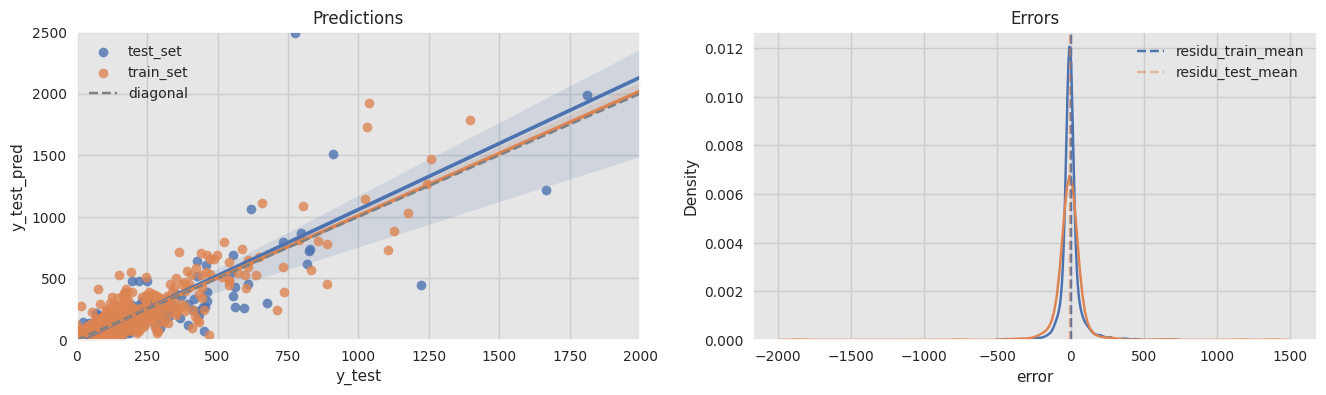

In [80]:
fig, ax = plt.subplots(1,2,figsize = (16,4))

ax = ax.flatten()

sns.regplot(y=y_test, x = lasso.predict(X_test), label='test_set', ax=ax[0])
sns.regplot(y=y_train, x = lasso.predict(X_train), label='train_set', ax=ax[0])
ax[0].axline(xy1=(0,0), slope=1, color='gray', linestyle='--', label='diagonal')
ax[0].legend(loc='upper left')
ax[0].set(title='Predictions', xlabel='y_test', ylabel='y_test_pred')
ax[0].set_xlim(0,2000)
ax[0].set_ylim(0,2500)

x = residu_train[residu_train < np.quantile(residu_train, 1)]
sns.kdeplot(x = x, ax  = ax[1])
x = residu_test[residu_test < np.quantile(residu_test, 1)]
sns.kdeplot(x = x, ax  = ax[1])
ax[1].axvline(x=residu_train.mean(), color=sns_c[0], linestyle='--', label='residu_train_mean')
ax[1].axvline(x=residu_test.mean(), color=sns_c[1], linestyle='--', label='residu_test_mean', alpha = 0.5)
ax[1].legend(loc='upper right')
ax[1].set(title='Errors', xlabel= 'error')

plt.show()

In [81]:
x_train_preprocessor= linear_preprocessor.transform(X_train).todense()
x_train_preprocessor=np.asarray(x_train_preprocessor)

/home/bryan/anaconda3/envs/KeFlow/lib/python3.7/site-packages/yellowbrick/regressor/influence.py:157: RuntimeWarning: invalid value encountered in sqrt
  residuals_studentized = residuals / np.sqrt(mse) / np.sqrt(1 - leverage)


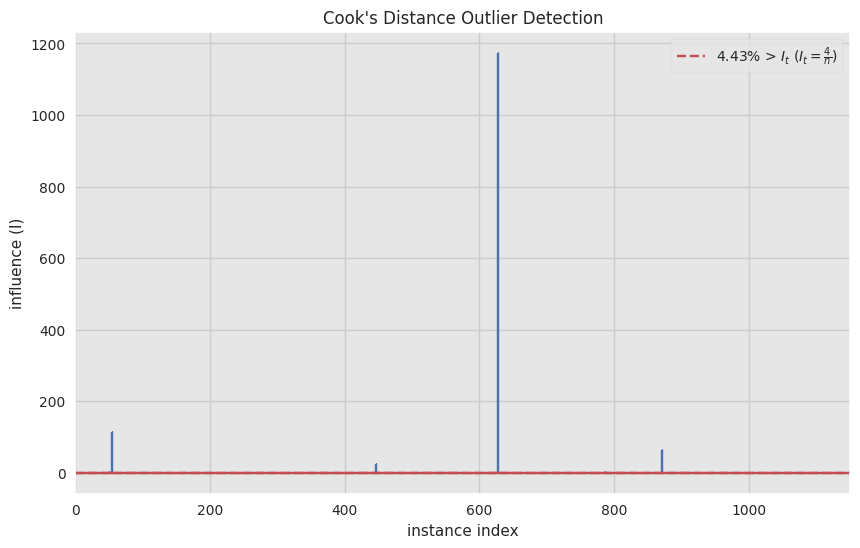

<AxesSubplot:title={'center':"Cook's Distance Outlier Detection"}, xlabel='instance index', ylabel='influence (I)'>

In [82]:
from yellowbrick.regressor import CooksDistance
from yellowbrick.datasets import load_concrete



# Instantiate and fit the visualizer
visualizer = CooksDistance()
visualizer.fit(x_train_preprocessor,np.asarray(y_train))
visualizer.show()

In [157]:
cook_distance = pd.Series(visualizer.distance_)
cook_distance = cook_distance.sort_values(ascending = False)

In [195]:
X_train.columns

Index(['LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
       'ThirdLargestPropertyUseTypeGFA', 'Electricity_p', 'NaturalGaz_p',
       'Latitude', 'Longitude', 'NonResidentialGFA', 'PropertyGFAParking',
       'PropertyGFABuilding(s)', 'ENERGYSTARScore', 'PrimaryPropertyType',
       'BuildingType', 'LargestPropertyUseType'],
      dtype='object')

In [196]:
X_train.iloc[cook_distance[:4].index][['BuildingType','Electricity_p','ENERGYSTARScore','LargestPropertyUseType']]

,BuildingType,Electricity_p,ENERGYSTARScore,LargestPropertyUseType
2814,Multifamily HR (10+),1.000000,46.0,Senior Care Community
529,NonResidential,0.689684,89.0,Other
20,NonResidential,0.541472,76.0,Courthouse
35,Campus,0.335596,8.0,Office


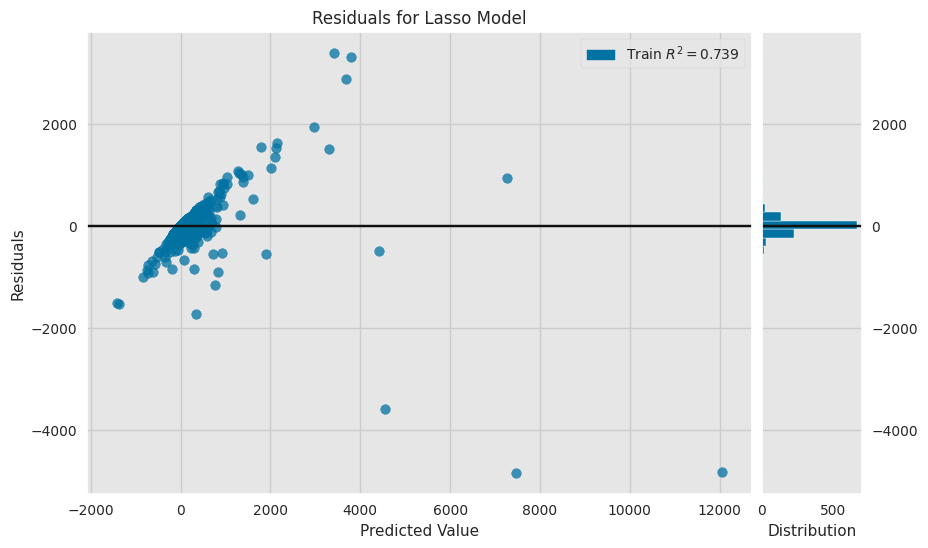

<AxesSubplot:title={'center':'Residuals for Lasso Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [84]:
from sklearn.linear_model import LinearRegression
from yellowbrick.regressor import ResidualsPlot

# Instantiate and fit the visualizer
model = Lasso()
visualizer_residuals = ResidualsPlot(model)
visualizer_residuals.fit(x_train_preprocessor,np.asarray(y_train))
visualizer_residuals.show()

## 3.2 coefficient de la regression

In [85]:
#extraction des variables explicatives apres transformation
lasso_features = lasso[:-1].get_feature_names_out()
len(lasso_features)

737

In [86]:
lasso[-1].coef_

array([-0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  6.65163819e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        9.71915976e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00, -1.26547551e+01,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  2.29342092e+01, -0.00000000e+00, -0.00000000e+00,
        4.35825702e+01,  0.00000000e+00, -0.00000000e+00, -8.19610017e+01,
       -0.00000000e+00,  

In [87]:
data = {'lasso_features':  lasso_features,
        'coef' : lasso[-1].coef_}

In [88]:
lasso_coef_df = pd.DataFrame(data)
#coef en valeur absolue
lasso_coef_df = lasso_coef_df.assign(abs_coef = lambda x: x['coef'].abs())
#tri 
lasso_coef_df=lasso_coef_df.sort_values(by='abs_coef', ascending =False).reset_index(drop = True)
# Get top (abs) beta coefficients.
lasso_coef_df.head(13).style.background_gradient(cmap='cividis_r',axis=0,subset=['coef','abs_coef'])

,lasso_features,coef,abs_coef
0,cat__PrimaryPropertyType_Hospital num__LargestPropertyUseTypeGFA,564.288905,564.288905
1,cat__LargestPropertyUseType_Data Center num__SecondLargestPropertyUseTypeGFA,202.919557,202.919557
2,cat__LargestPropertyUseType_Hospital (General Medical & Surgical) num__LargestPropertyUseTypeGFA,119.925927,119.925927
3,num__NonResidentialGFA,116.716707,116.716707
4,num__LargestPropertyUseTypeGFA num__Electricity_p,-105.089928,105.089928
5,num__Electricity_p,-81.961002,81.961002
6,num__LargestPropertyUseTypeGFA num__ENERGYSTARScore,-80.992659,80.992659
7,num__SecondLargestPropertyUseTypeGFA num__ThirdLargestPropertyUseTypeGFA,57.790781,57.790781
8,num__SecondLargestPropertyUseTypeGFA num__ENERGYSTARScore,52.210155,52.210155
9,num__PropertyGFABuilding(s),51.526623,51.526623


In [89]:
lasso_effects = np.multiply(
    lasso[-1].coef_,
    lasso[0].transform(X_train).todense()
)

In [90]:
lasso_effects_df = pd.DataFrame(
    data=lasso_effects,
    columns=lasso_features
)
lasso_effects_df.shape

(1151, 737)

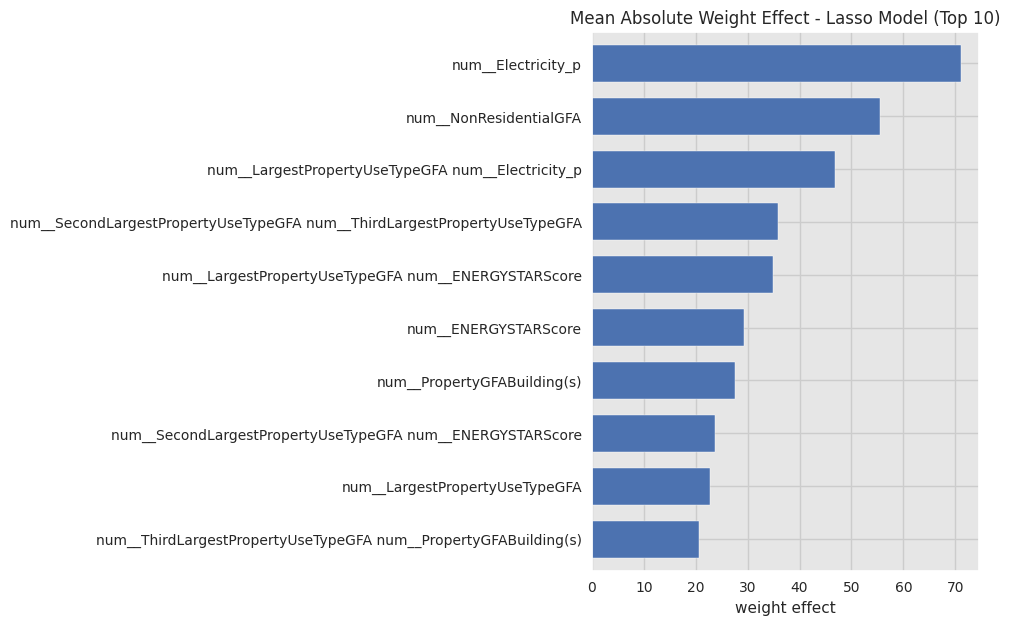

In [91]:
fig, ax = plt.subplots(figsize=(5, 7))
lasso_effects_df.abs().mean(axis=0).sort_values().tail(10).plot(kind='barh',ax=ax,align='center', width = 0.7)
ax.set(title='Mean Absolute Weight Effect - Lasso Model (Top 10)',xlabel='weight effect')
plt.show()

## 3.3 Permutation Importance

In [92]:
from sklearn.inspection import permutation_importance

In [93]:
lasso_pi = permutation_importance(
    estimator=lasso,
    X=X_train,
    y=y_train,
    n_repeats=10
)
#retourn a dictionnary with 3 keys :('importances_mean', 'importances_std','importances')
lasso_pi['importances'].shape

(14, 10)

In [94]:
lasso_pi.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [95]:
lasso_pi['importances_mean']

array([3.89865506e-01, 4.38626510e-01, 3.53548912e-01, 1.03934668e-01,
       1.36329135e-04, 1.24056979e-05, 2.13690984e-06, 9.36106402e-02,
       8.70485867e-04, 1.04752993e-01, 2.73974892e-02, 1.05982221e-01,
       6.96209133e-04, 1.06057288e-02])

In [96]:
X_train.columns.shape

(14,)

In [97]:
d = {'importances_mean':lasso_pi['importances_mean'],'importances_std':lasso_pi['importances_std']}
lasso_pi_df= pd.DataFrame(data = d,
                          index =X_train.columns )

In [98]:
lasso_pi_df =lasso_pi_df.sort_values(by = 'importances_mean', ascending = False)

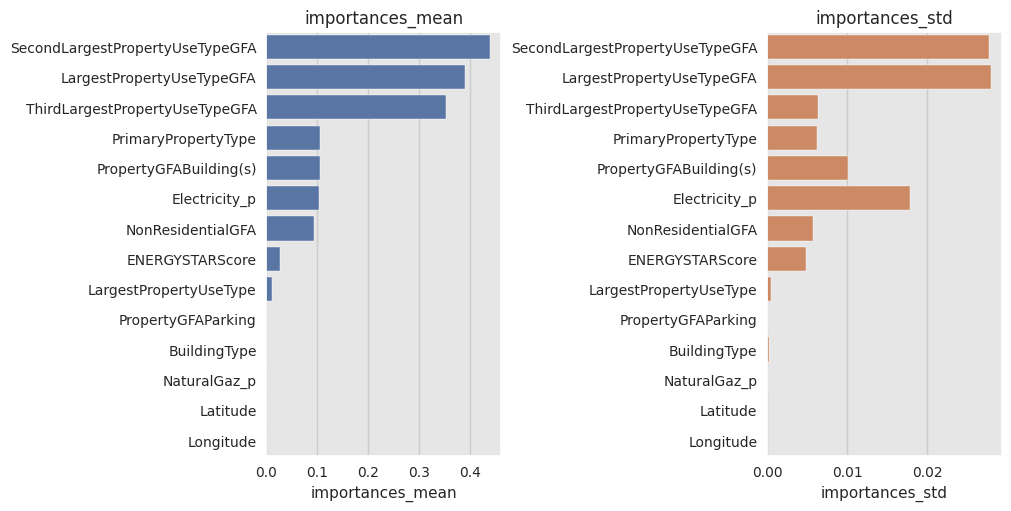

In [99]:
fig, ax = plt.subplots(1,2, figsize=(10, 5), constrained_layout=True)

sns.barplot(
    data = lasso_pi_df,
    x='importances_mean',
    y=lasso_pi_df.index,
    orient='h',
    color=sns_c[0],
    ax=ax[0])

sns.barplot(
    data = lasso_pi_df,
    x='importances_std',
    y=lasso_pi_df.index,
    orient='h',
    color=sns_c[1],
    ax=ax[1]
)

ax[0].set(title='importances_mean')
ax[1].set(title='importances_std')

plt.show()

## 3.4 Interpretation 

### Globale

https://armand-sauzay.medium.com/shap-values-machine-learning-interpretability-and-feature-selection-made-easy-feb8765f815b

https://medium.com/@ulalaparis/repousser-les-limites-dexplicabilit%C3%A9-un-guide-avanc%C3%A9-de-shap-a33813a4bbfc

In [166]:
import shap

In [167]:
data  = lasso[:-1].transform(X_train)
lasso_x_train = pd.DataFrame(data=data.todense(),columns=lasso_features )
lasso_x_train.shape

data  = lasso[:-1].transform(X_train)
lasso_x_test = pd.DataFrame(data=data.todense(),columns=lasso_features )
lasso_x_test.shape

(1151, 737)

In [168]:
masker = shap.maskers.Independent(data = lasso_x_train,max_samples = 500)
lasso_shap_explainer = shap.LinearExplainer(
    model = lasso[-1],
    masker = masker #background data
)

In [169]:
lasso_shap_values = lasso_shap_explainer(lasso_x_test)

In [170]:
lasso_shap_values.data.shape

(1151, 737)

In [171]:
lasso_shap_explainer.expected_value

176.199988167038

In [172]:
lasso_shap_values.base_values

array([176.19998817, 176.19998817, 176.19998817, ..., 176.19998817,
       176.19998817, 176.19998817])

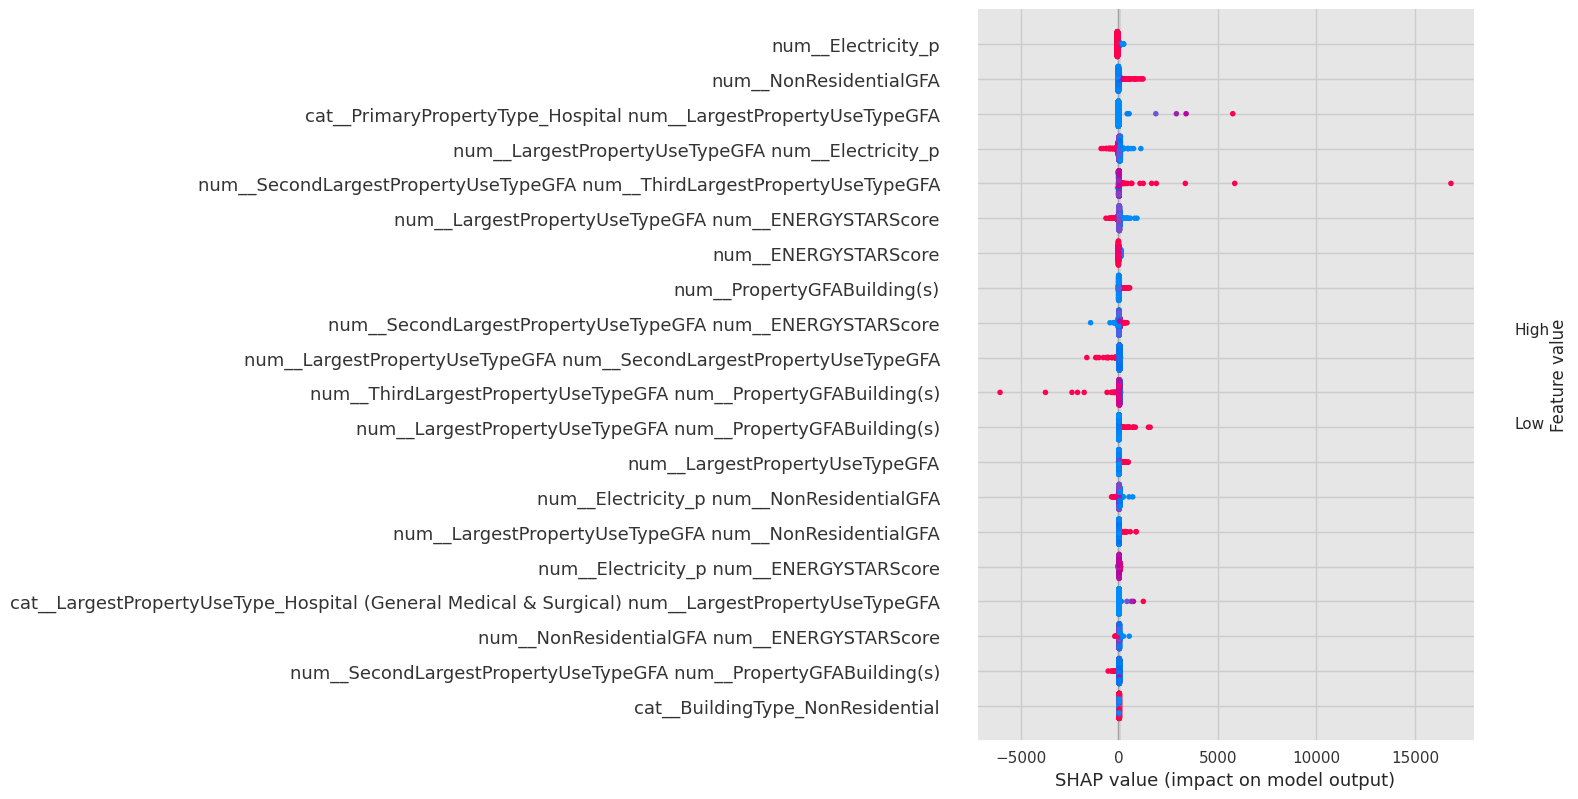

In [173]:
shap.summary_plot(lasso_shap_values, max_display = 20, show = True)

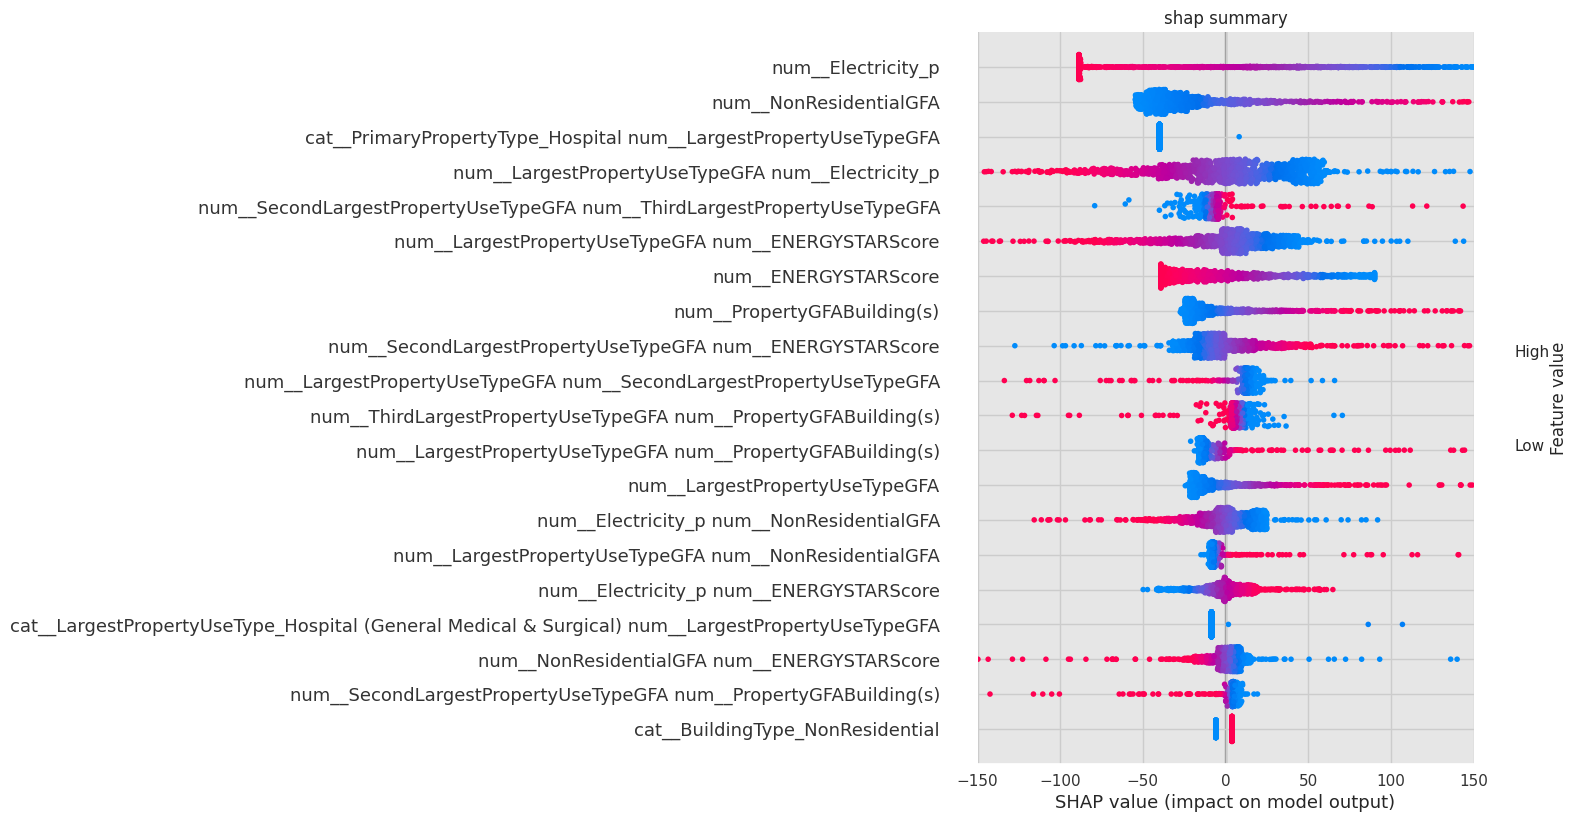

In [174]:
shap.summary_plot(lasso_shap_values, max_display = 20, show = False)
plt.xlim(-150,+150)
plt.title('shap summary')
plt.show()

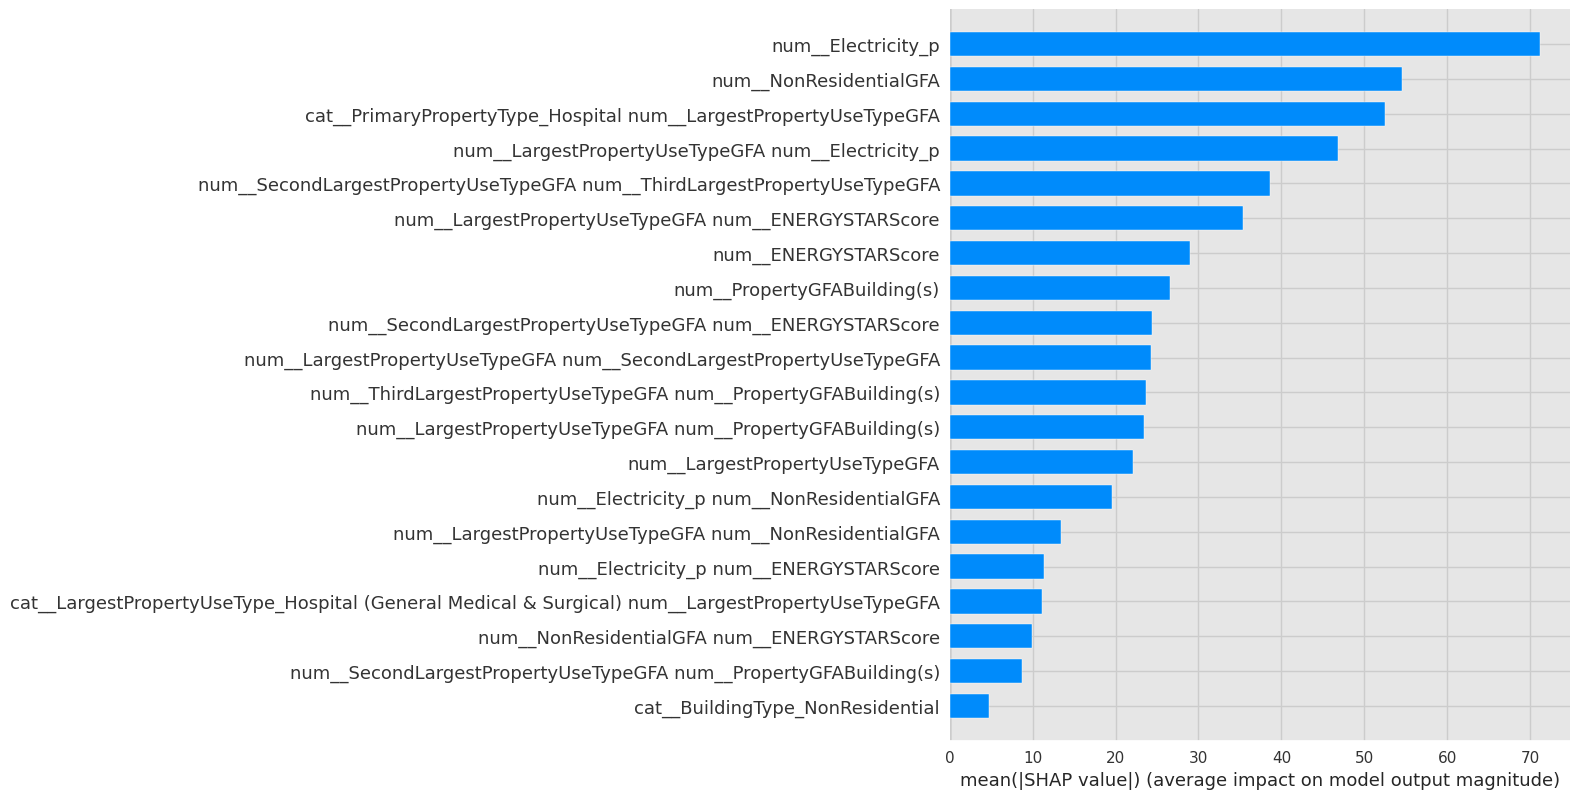

In [175]:
shap.summary_plot(lasso_shap_values, max_display= 20, show=False, plot_type = 'bar')

Text(0.5, 1.0, 'SHAP Values Aggregation Linear Model')

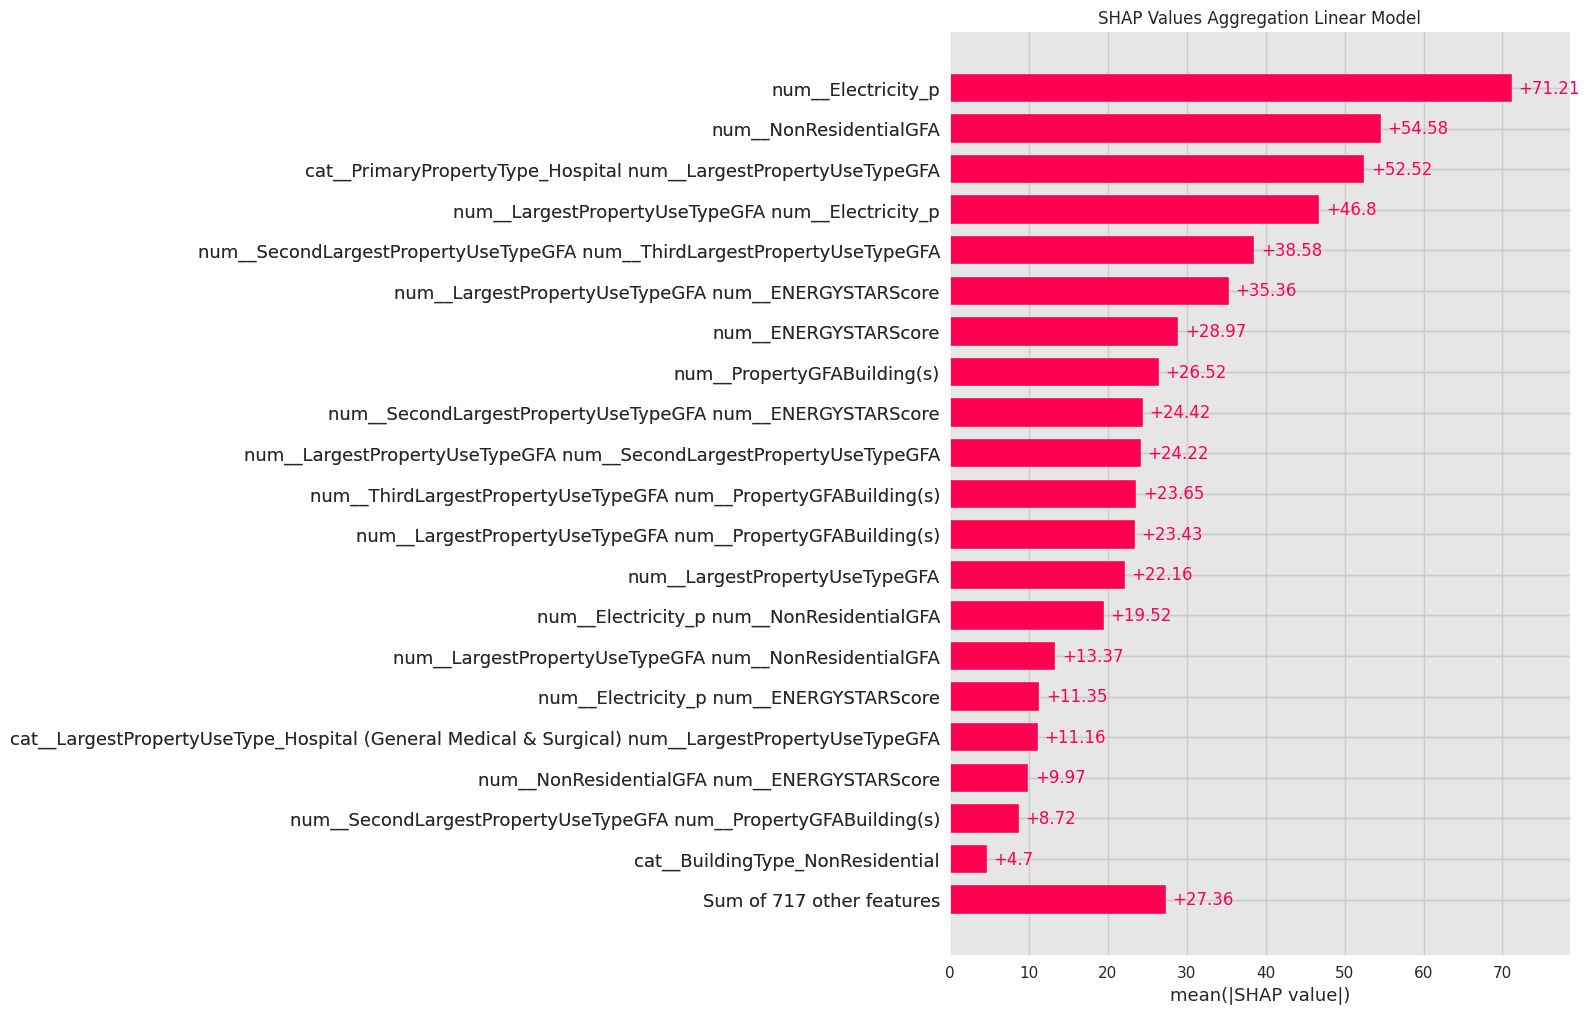

In [190]:
shap.plots.bar(shap_values=lasso_shap_values, max_display=21, show=False)
plt.title('SHAP Values Aggregation Linear Model')

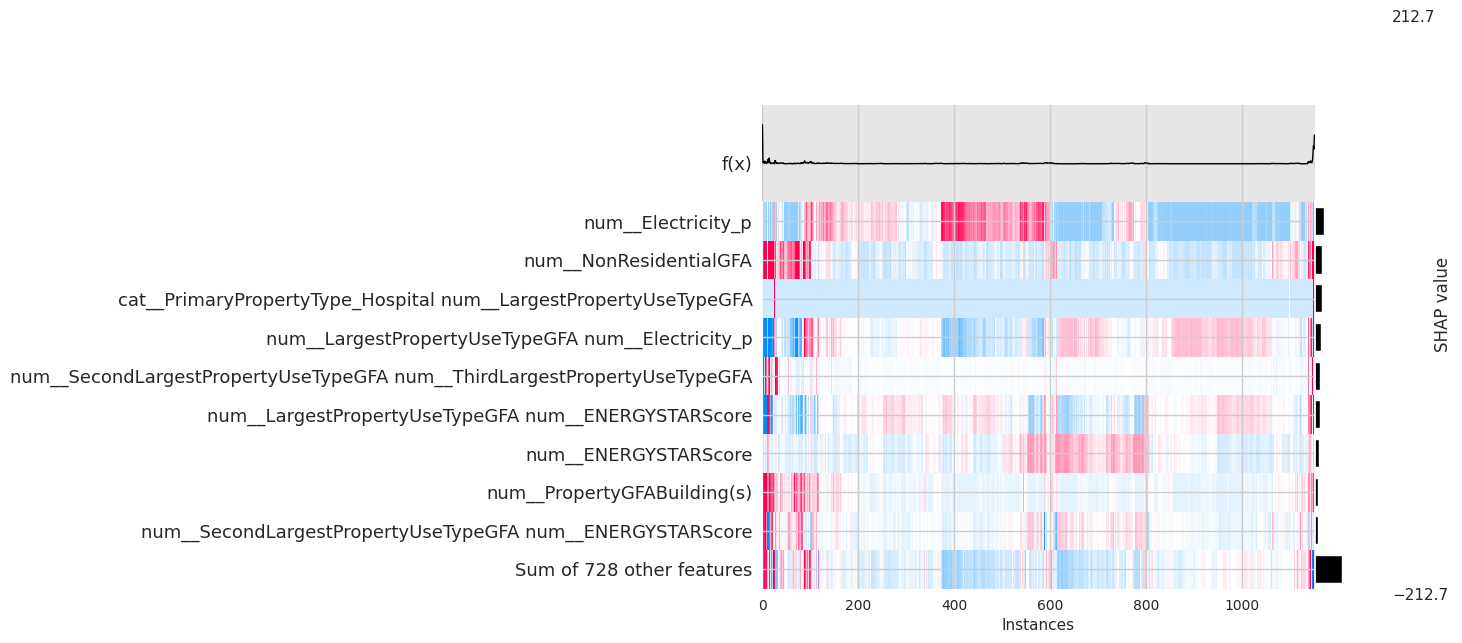

In [177]:
shap.plots.heatmap(lasso_shap_values)

In [178]:
cook_distance[:5]

627    1174.204254
55      112.969793
871      62.785161
446      23.495109
786       2.054049
dtype: float64

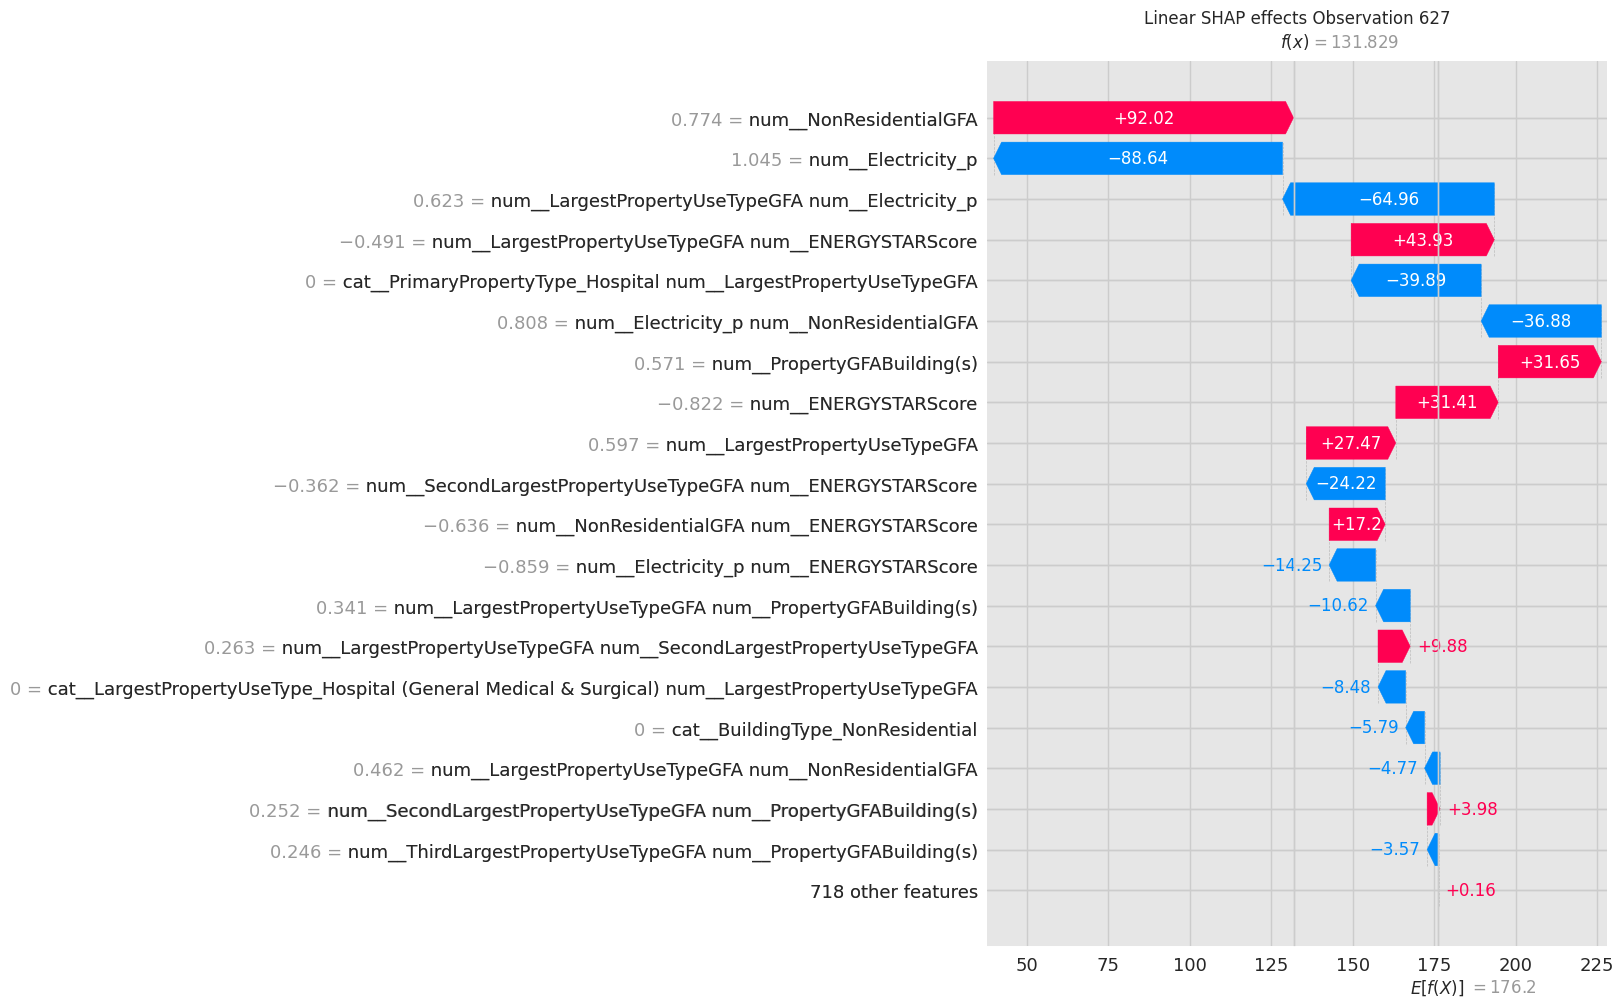

In [199]:
obs_index = 627
shap.plots.waterfall(
    shap_values=lasso_shap_values[obs_index],
    max_display=20,
    show=False
)
plt.title(f'Linear SHAP effects Observation {obs_index}');

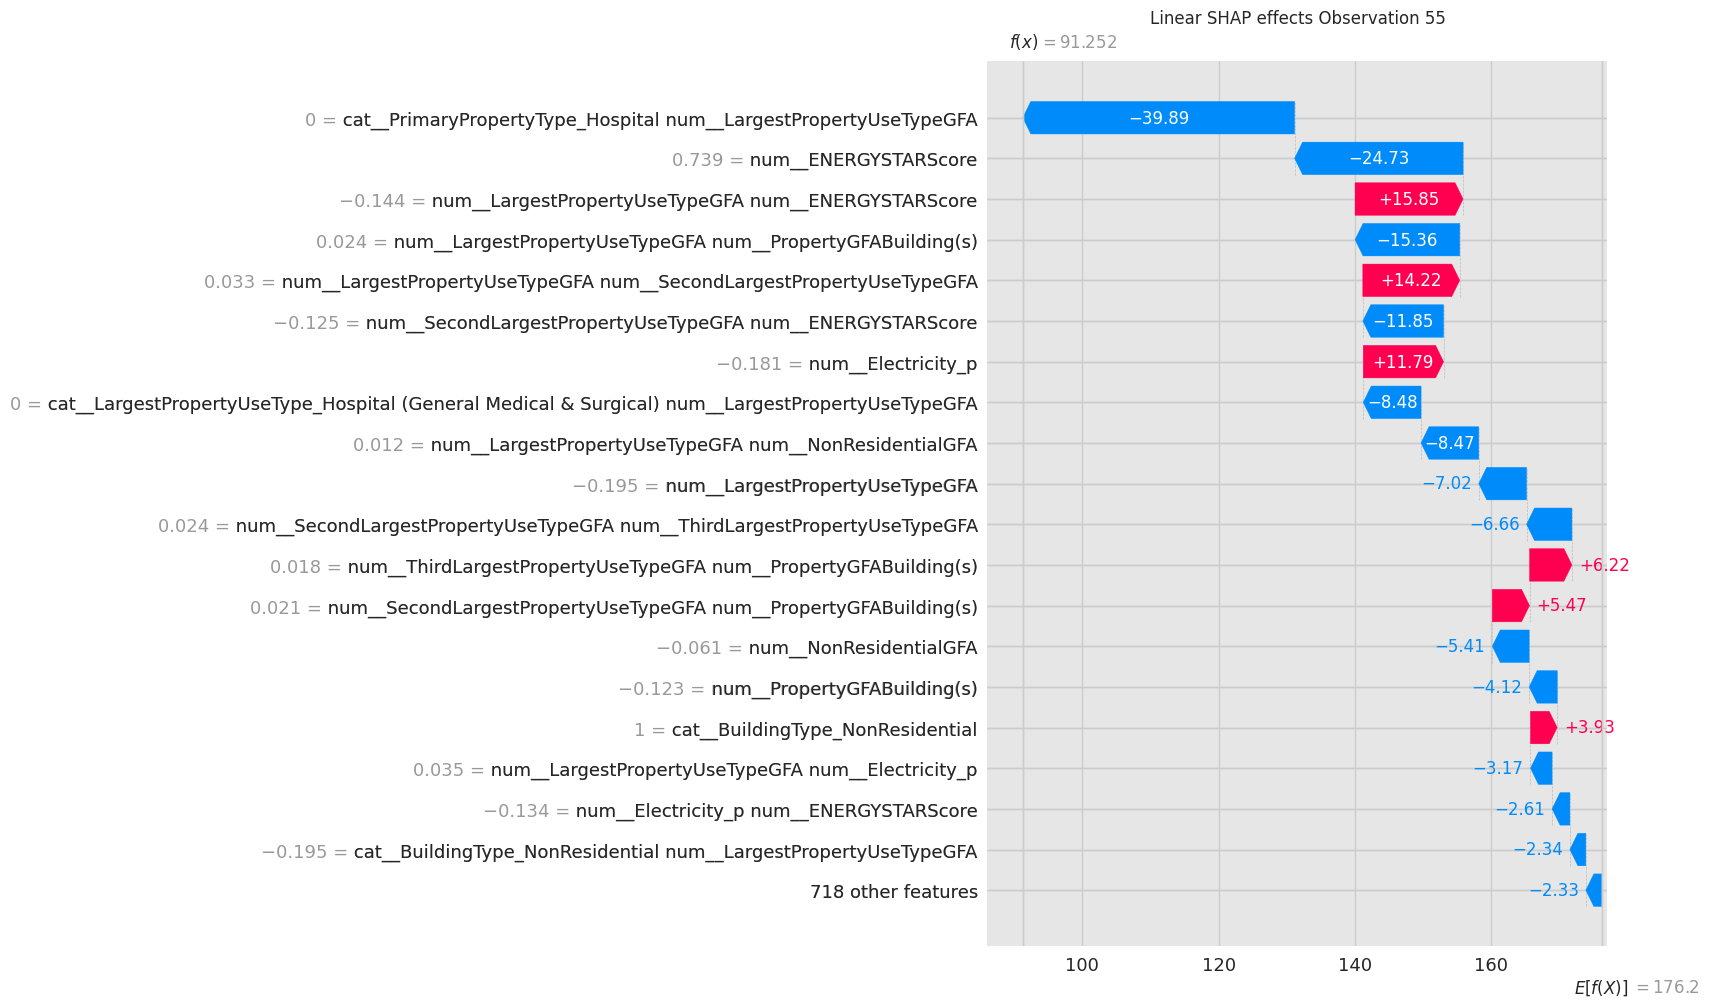

In [180]:
obs_index = 55
shap.plots.waterfall(
    shap_values=lasso_shap_values[obs_index],
    max_display=20,
    show=False
)
plt.title(f'Linear SHAP effects Observation {obs_index}');

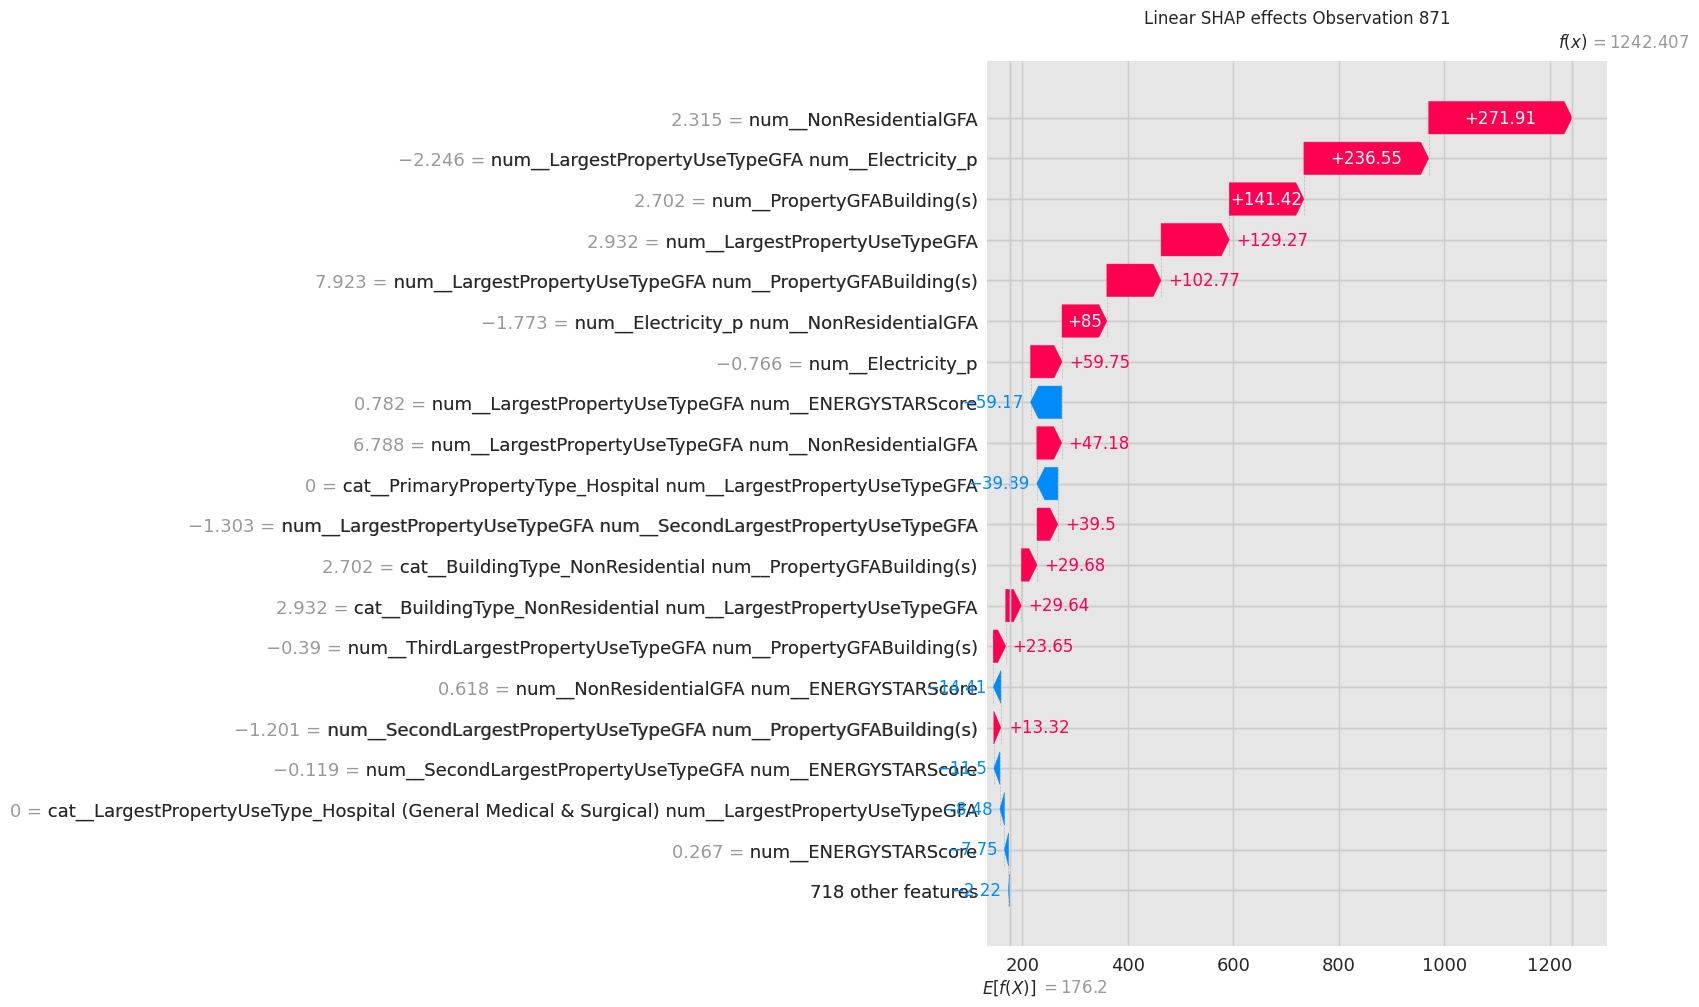

In [181]:
obs_index = 871
shap.plots.waterfall(
    shap_values=lasso_shap_values[obs_index],
    max_display=20,
    show=False
)
plt.title(f'Linear SHAP effects Observation {obs_index}');

In [182]:
X_train.iloc[cook_distance[:4].index]

,LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,Electricity_p,NaturalGaz_p,Latitude,Longitude,NonResidentialGFA,PropertyGFAParking,PropertyGFABuilding(s),ENERGYSTARScore,PrimaryPropertyType,BuildingType,LargestPropertyUseType
2814,186486.0,43568.0,11335.0,1.000000,0.000000,47.62684,-122.35736,241389,43568,197819,46.0,Senior Care Community,Multifamily HR (10+),Senior Care Community
529,67670.0,13534.0,0.0,0.689684,0.310316,47.60223,-122.33602,81204,0,86204,89.0,Retail Store,NonResidential,Other
20,537150.0,0.0,0.0,0.541472,0.458528,47.60265,-122.33051,537150,0,540360,76.0,Other,NonResidential,Courthouse
35,757027.0,639931.0,459748.0,0.335596,0.664404,47.53493,-122.31788,1856706,0,494835,8.0,Mixed Use Property,Campus,Office
